In [389]:
import numpy as np
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from catboost.utils import get_confusion_matrix
from sklearn.metrics import classification_report

In [332]:
df = pd.read_csv("datasets/hse_data_science_hack/train.csv", index_col=[0])

In [333]:
from bokeh.io import output_notebook, push_notebook, show
from bokeh.models import (
    ColumnDataSource, GMapOptions, LinearColorMapper,
    FactorRange, ColorBar, BasicTicker, PrintfTickFormatter
)
from bokeh.palettes import Spectral3, Spectral6, Spectral7
from bokeh.plotting import figure
from bokeh.transform import factor_cmap
from bokeh.plotting import gmap
from bokeh.layouts import gridplot, row

output_notebook() 

Loading BokehJS ...

In [334]:
pos = df[df['sentiment']=='+']
neg = df[df['sentiment']=='−']

In [335]:
label_vc = df['sentiment'].value_counts()

source = ColumnDataSource(
    data=dict(labels=label_vc.index, counts=label_vc.values))

TOOLS="hover,crosshair,pan,wheel_zoom,zoom_in,zoom_out,box_zoom,undo,redo,reset,tap,save,box_select,poly_select,lasso_select,"
COLORS5 = ['#ED553B', '#3CAE75', '#F6D55C']
p = figure(
#     tools=TOOLS,
#     toolbar_location='above',
    x_range=df['sentiment'].unique(),
    height=550, 
    title="Sentiments Distribution")

p.vbar(x='labels', top='counts', width=0.9, source=source,
       line_color='white', 
       fill_color=factor_cmap('labels', palette=COLORS5, factors=label_vc.index))

p.xgrid.grid_line_color = None
p.y_range.start = 0
p.y_range.end = label_vc.max()

show(p)

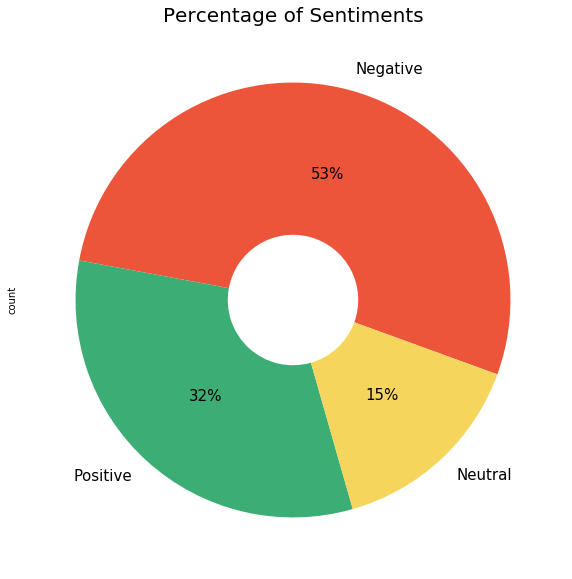

In [336]:
plt.figure(figsize=(30,10))
plt.title('Percentage of Sentiments', fontsize=20)
df.sentiment.value_counts().plot(kind='pie', colors=COLORS5, labels=['Negative', 'Positive', 'Neutral'],
                              wedgeprops=dict(width=.7), autopct='%1.0f%%', startangle= -20, 
                              textprops={'fontsize': 15})

In [337]:
# mean word count in a message
np.mean(df['sentence'].map(lambda x: np.mean([len(word) for word in x.split()])))

5.9731536964323535

In [338]:
np.mean(pos['sentence'].map(lambda x: np.mean([len(word) for word in x.split()])))

6.241132113594342

In [339]:
np.mean(neg['sentence'].map(lambda x: np.mean([len(word) for word in x.split()])))

5.864415191253101

In [340]:
extra_stops = ['это', 'который', 'всё']
stopwords = stopwords.words('russian')
for word in extra_stops:
    stopwords.append(word)

In [341]:
text = ' '.join(df['sentence'].astype(str).str.lower().tolist())
wc = WordCloud().generate_from_text(text)

def generate_basic_wordcloud(data):
    cloud = WordCloud(width=600,
                      height=480,
                      background_color='white',
                      max_words=150,
                      colormap='tab20c',
                      stopwords=stopwords,
                      collocations=True).generate_from_text(data)
    plt.figure(figsize=(15,12))
    plt.imshow(cloud)
    plt.axis('off')
    plt.show()

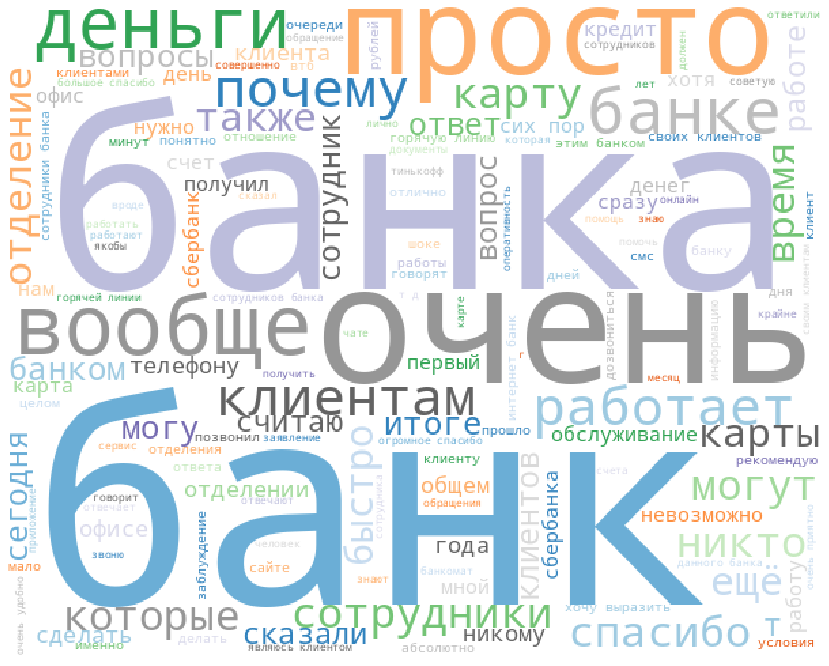

In [342]:
# general word cloud on unlemmatized data

generate_basic_wordcloud(text)

In [343]:
with open('corpus_lemmatized.txt') as f:
    lemmatized = f.readlines()
    f.close()

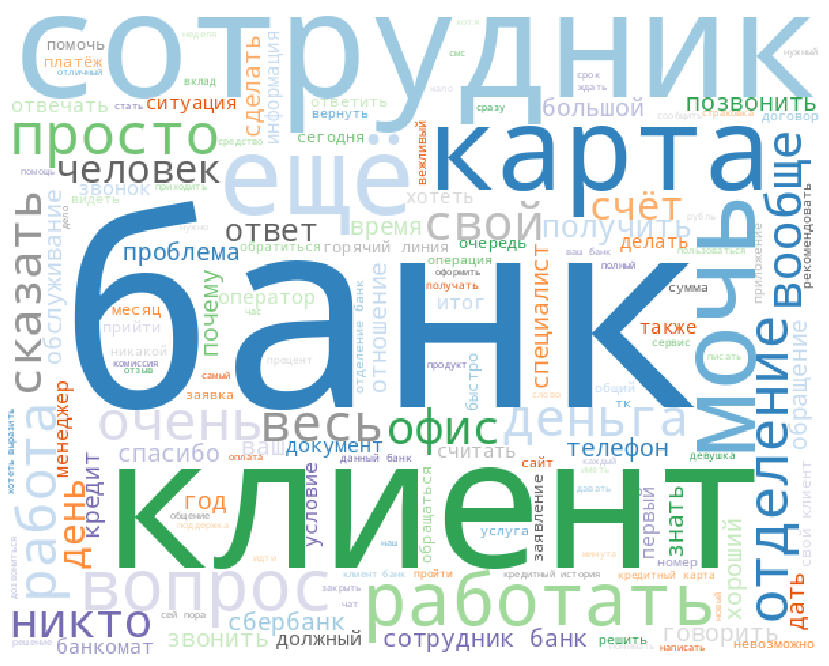

In [344]:
# general word cloud on lemmatized data

generate_basic_wordcloud(' '.join(lemmatized))

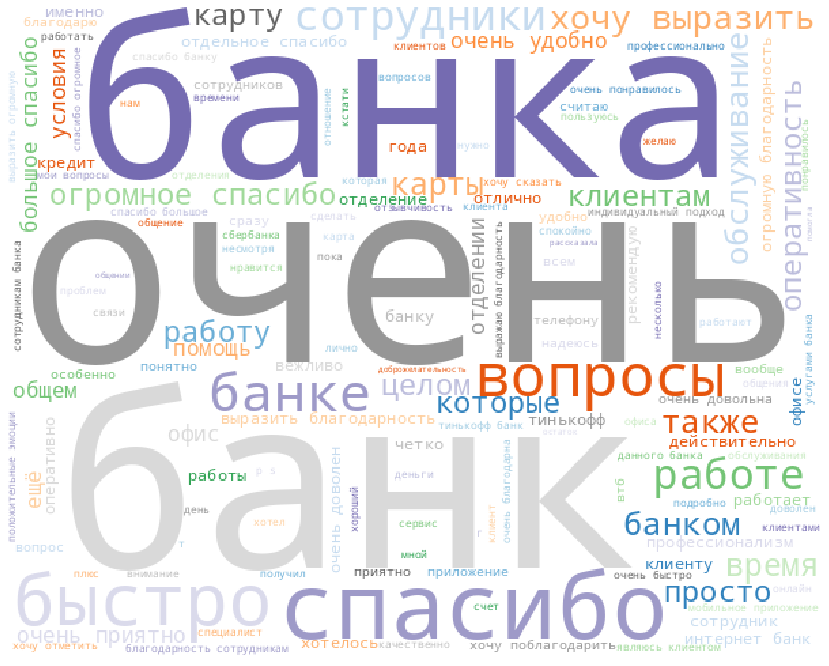

In [345]:
# positive messages wordcloud

text = ' '.join(pos['sentence'].astype(str).str.lower().tolist())
generate_basic_wordcloud(text)

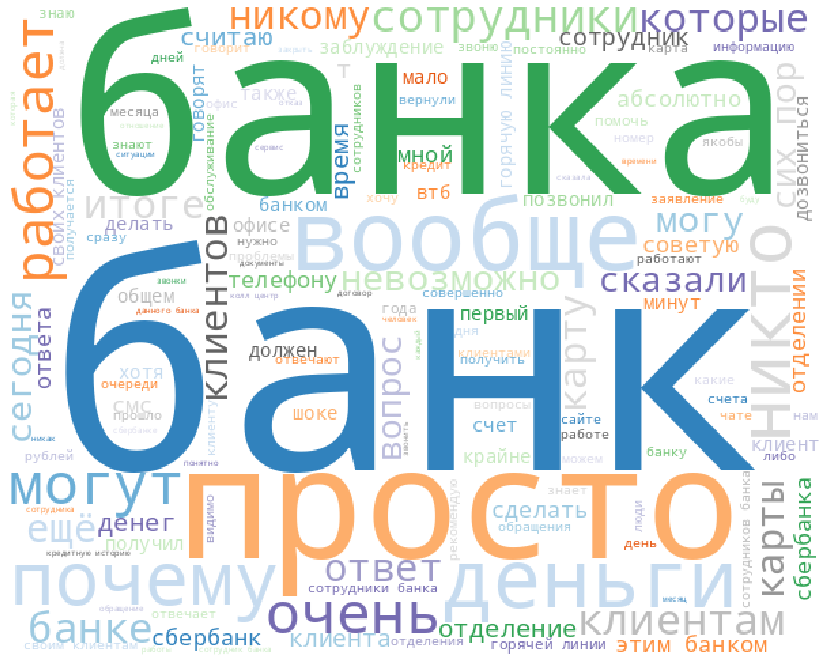

In [346]:
# negative messages wordcloud

text = ' '.join(neg['sentence'].astype(str).str.lower().tolist())
generate_basic_wordcloud(text)

## CatBoost Classifier

In [392]:
from catboost import CatBoostClassifier, Pool
from catboost.utils import get_roc_curve

In [348]:
def fit_model(train_pool, test_pool, **kwargs):
    model = CatBoostClassifier(
#         task_type='GPU',
        iterations=7000,
        eval_metric='Accuracy',
        od_type='Iter',
        od_wait=500,
        **kwargs
    )

    return model.fit(
        train_pool,
        eval_set=test_pool,
        verbose=100,
        plot=True,
        use_best_model=True)

In [393]:
#!c1.32
df_ = df.loc[df.index][['sentence', 'sentiment']]

In [394]:
df_

,sentence,sentiment
4754,При этом всегда получал качественные услуги.,+
4417,"Не вижу, за что хотя бы 2 поставить, сервис на 1!",−
3629,"Вот так ""Мой любимый"" банк МКБ меня обманул.",−
11640,Отвратительное отношение к клиентам.,−
5571,"Всегда в любое время дня и ночи помогут, ответ...",+
...,...,...
8004,Никогда и ни в коем случае не открывайте счет ...,−
18182,ТИ откровенно забили на качество и развивают с...,−
744,"Я считаю, это прорыв и лидерство финансовых ус...",+
6220,"Писал мужчина очень доходчиво, не финансовым я...",+


In [395]:
train, test = train_test_split(
    df_,
    train_size=0.9,
    random_state=0,
    stratify=df_['sentiment'])

y_train, X_train = \
    train['sentiment'], train.drop(['sentiment'], axis=1)
y_test, X_test = \
    test['sentiment'], test.drop(['sentiment'], axis=1)

In [396]:
#!c1.32
train_pool = Pool(
    data=X_train.values,
    label=y_train.values,
    text_features=['sentence'],
    feature_names=X_train.columns.tolist()
)

test_pool = Pool(
    data=X_test.values, 
    label=y_test.values,
    text_features=['sentence'],
    feature_names=X_test.columns.tolist()
)

In [353]:
#!c1.32
model = fit_model(
    train_pool, test_pool,
    learning_rate=0.35,
    tokenizers=[
        {
            'tokenizer_id': 'Sense',
            'separator_type': 'BySense',
            'lowercasing': 'True',
            'token_types':['Word', 'Number', 'SentenceBreak'],
            'sub_tokens_policy':'SeveralTokens'
        }      
    ],
    dictionaries = [
        {
            'dictionary_id': 'Word',
            'max_dictionary_size': '50000'
        }
    ],
    feature_calcers = [
        'BoW:top_tokens_count=10000'
    ]
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6013545	test: 0.5916366	best: 0.5916366 (0)	total: 328ms	remaining: 38m 18s
100:	learn: 0.7813935	test: 0.7392876	best: 0.7392876 (100)	total: 11.1s	remaining: 12m 40s
200:	learn: 0.8153122	test: 0.7640681	best: 0.7656169 (192)	total: 21.8s	remaining: 12m 17s
300:	learn: 0.8395317	test: 0.7862674	best: 0.7862674 (296)	total: 33.1s	remaining: 12m 15s
400:	learn: 0.8570937	test: 0.7924626	best: 0.7950439 (389)	total: 43.4s	remaining: 11m 54s
500:	learn: 0.8702365	test: 0.7976252	best: 0.7976252 (489)	total: 53.9s	remaining: 11m 38s
600:	learn: 0.8797635	test: 0.8079504	best: 0.8084667 (580)	total: 1m 5s	remaining: 11m 35s
700:	learn: 0.8861915	test: 0.8151781	best: 0.8156944 (691)	total: 1m 15s	remaining: 11m 17s
800:	learn: 0.8921028	test: 0.8187919	best: 0.8187919 (774)	total: 1m 26s	remaining: 11m 7s
900:	learn: 0.8980716	test: 0.8229220	best: 0.8249871 (876)	total: 1m 36s	remaining: 10m 54s
1000:	learn: 0.9018595	test: 0.8327310	best: 0.8332473 (989)	total: 1m 46s	remaini

In [358]:
#!c1.32
model.save_model('cb')

In [412]:
#!c1.32
model = CatBoostClassifier().load_model('cb')

In [359]:
#!c1.32
cf_matrix = get_confusion_matrix(model, test_pool)

In [360]:
#!c1.32
cf_matrix

array([[564.,  35.,  27.],
       [ 59., 144.,  88.],
       [ 25.,  41., 954.]])

In [361]:
#!c1.32
import seaborn as sns
import numpy as np

In [362]:
#!c1.32
target_names = ['Negative', 'Neutral', 'Positive']

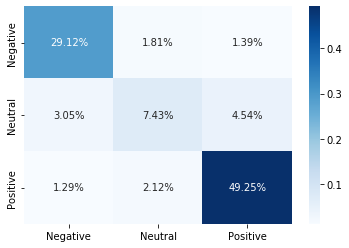

In [363]:
#!c1.32
sns.heatmap(
    cf_matrix/np.sum(cf_matrix),
    annot=True, fmt='.2%', cmap='Blues',
    xticklabels=target_names,
    yticklabels=target_names)

In [413]:
#!c1.32
y_proba_cb = model.predict_proba(test_pool)
y_pred = np.argmax(y_proba_cb, axis=1)

In [414]:
#!c1.32
print(classification_report(
    test['sentiment'].astype('category').cat.codes.values,
    y_pred))

              precision    recall  f1-score   support

           0       0.87      0.90      0.89       626
           1       0.65      0.49      0.56       291
           2       0.89      0.94      0.91      1020

    accuracy                           0.86      1937
   macro avg       0.81      0.78      0.79      1937
weighted avg       0.85      0.86      0.85      1937



In [415]:
#!c1.32
from sklearn import metrics
auc = metrics.roc_auc_score(test['sentiment'], y_proba_cb, multi_class='ovr')
auc

0.9304409693326644

In [425]:
#!c1.32
y_pred[:30]

array([0, 0, 2, 2, 0, 2, 2, 2, 2, 0, 0, 2, 1, 2, 0, 2, 0, 0, 0, 2, 0, 0,
       2, 0, 2, 1, 0, 0, 2, 0])

In [421]:
#!c1.32
y_proba_cb

array([[0.98320614, 0.01073597, 0.00605789],
       [0.81618281, 0.11354992, 0.07026727],
       [0.01710531, 0.03645555, 0.94643914],
       ...,
       [0.26855927, 0.1024965 , 0.62894423],
       [0.03852881, 0.03576347, 0.92570772],
       [0.66043944, 0.25859631, 0.08096425]])

In [436]:
#!c1.32
y_train[:30]

4660     +
1187     ?
12580    −
8255     −
5636     +
12123    −
21121    −
10688    −
18785    +
8599     −
6150     +
13233    +
852      +
10724    −
8839     −
9072     −
14617    +
12956    +
1184     ?
19018    −
3025     −
14293    +
8648     −
14174    +
2200     ?
1485     ?
7074     ?
18421    −
14481    +
5975     +
Name: sentiment, dtype: object

In [536]:
#!c1.32
test = pd.read_csv('new_test.csv', index_col=False)

In [537]:
#!c1.32
test

,Unnamed: 0,sentence
0,4036,15.03.2022 обратился на горячую линию для закр...
1,5804,"Уже который год в ТКБ не решается ""глобальная ..."
2,2752,Добрый день. Хочу оставить отзыв о пользовании...
3,1921,"Добрый день Сегодня, зайдя в свой личный кабин..."
4,7374,"Обслуживаюсь в Тинькофф пару лет, возникла жес..."
...,...,...
995,146,Отвратительный сервис и отношение к клиентам! ...
996,2677,28.04.2022 обратилась в банк о возможности пер...
997,4481,В начале 2021 года была акция по выплате 8% ке...
998,4112,Бездействие банка и некомпетентность сотрудник...


In [538]:
#!c1.32
test_pool_final = Pool(
    data=test.values, 
    label=test.values,
    text_features=['sentence'],
    feature_names=test.columns.tolist()
)

TypeError: must be real number, not str

In [ ]:
#!c1.32
y_pred_final = model.predict(test_pool_final)
y_proba_cb_final = model.predict_proba(test_pool_final)

In [ ]:
#!c1.32
len(y_proba_cb_final)

In [539]:
#!c1.32
y_pred_final[:10]

array([['−'],
       ['−'],
       ['+'],
       ['−'],
       ['−'],
       ['−'],
       ['+'],
       ['−'],
       ['−'],
       ['?']], dtype=object)

- [2]
+ [0]
? [1]

In [540]:
#!c1.32
cols = ['+', '-', '?']
df1 = pd.DataFrame(y_proba_cb_final, columns=cols)

In [541]:
#!c1.32
test

,Unnamed: 0,sentence
0,4036,15.03.2022 обратился на горячую линию для закр...
1,5804,"Уже который год в ТКБ не решается ""глобальная ..."
2,2752,Добрый день. Хочу оставить отзыв о пользовании...
3,1921,"Добрый день Сегодня, зайдя в свой личный кабин..."
4,7374,"Обслуживаюсь в Тинькофф пару лет, возникла жес..."
...,...,...
995,146,Отвратительный сервис и отношение к клиентам! ...
996,2677,28.04.2022 обратилась в банк о возможности пер...
997,4481,В начале 2021 года была акция по выплате 8% ке...
998,4112,Бездействие банка и некомпетентность сотрудник...


In [542]:
#!c1.32
df1

,+,-,?
0,0.094878,0.110697,0.794425
1,0.019110,0.074773,0.906117
2,0.798549,0.087623,0.113828
3,0.030285,0.071149,0.898566
4,0.066023,0.081858,0.852119
...,...,...,...
995,0.046982,0.035335,0.917683
996,0.034080,0.551002,0.414918
997,0.010448,0.936629,0.052923
998,0.015925,0.018571,0.965503


In [543]:
#!c1.32
df2 = pd.concat([test, df1], axis=1)

In [544]:
#!c1.32
df2

,Unnamed: 0,sentence,+,-,?
0,4036,15.03.2022 обратился на горячую линию для закр...,0.094878,0.110697,0.794425
1,5804,"Уже который год в ТКБ не решается ""глобальная ...",0.019110,0.074773,0.906117
2,2752,Добрый день. Хочу оставить отзыв о пользовании...,0.798549,0.087623,0.113828
3,1921,"Добрый день Сегодня, зайдя в свой личный кабин...",0.030285,0.071149,0.898566
4,7374,"Обслуживаюсь в Тинькофф пару лет, возникла жес...",0.066023,0.081858,0.852119
...,...,...,...,...,...
995,146,Отвратительный сервис и отношение к клиентам! ...,0.046982,0.035335,0.917683
996,2677,28.04.2022 обратилась в банк о возможности пер...,0.034080,0.551002,0.414918
997,4481,В начале 2021 года была акция по выплате 8% ке...,0.010448,0.936629,0.052923
998,4112,Бездействие банка и некомпетентность сотрудник...,0.015925,0.018571,0.965503


In [547]:
#!c1.32
df2.to_csv('sentiments.csv', index=False)

In [484]:
#!c1.32
round(max(y_proba_cb_final[0]),2)

0.82

In [485]:
#!c1.32
y_proba_max = []
for i in y_proba_cb_final:
    y_proba_max.append(round(max(y_proba_cb_final[i]),2))
    

IndexError: arrays used as indices must be of integer (or boolean) type

In [ ]:
#!c1.32
y_proba_max

In [477]:
#!c1.32
y_proba_max = np.argmax(y_proba_cb_final, axis=1)

In [474]:
#!c1.32
test['sentiment'] = list(map(lambda x: x[0], y_pred_final))

In [475]:
#!c1.32
test

,sentence,sentiment
0,"Очень неприятная ситуация, надеюсь, банк либо ...",−
1,За что выражаю благодарность и банку и данному...,+
2,"Вывод: информация полученная в смс от банка, и...",−
3,Хочу по благодарить ее за чуткое отношение к н...,+
4,"Показал, что я и вклад могу свой пополнять пря...",+
...,...,...
2147,Верная (по их мнению) ставка 13%.,−
2148,Спасибо Промсвязьбанку за гибкий и человечески...,+
2149,"Это говорит о том, что обслуживание находится ...",+
2150,Без платежки ничего не принимают!,−


In [478]:
#!c1.32
y_proba_max

array([2, 0, 2, ..., 0, 2, 0])

## Tuning parameters with Optuna

In [398]:
#!c1.32
import catboost
import optuna
from optuna.samplers import TPESampler
from sklearn.metrics import accuracy_score

In [401]:
#!c1.32
def objective(trial):
    model = catboost.CatBoostClassifier(
        iterations=trial.suggest_int("iterations", 100, 1000),
        learning_rate=trial.suggest_float("learning_rate", 1e-3, 1e-1, log=True),
        depth=trial.suggest_int("depth", 4, 10),
        l2_leaf_reg=trial.suggest_float("l2_leaf_reg", 1e-8, 100.0, log=True),
        bootstrap_type=trial.suggest_categorical("bootstrap_type", ["Bayesian"]),
        random_strength=trial.suggest_float("random_strength", 1e-8, 10.0, log=True),
        bagging_temperature=trial.suggest_float("bagging_temperature", 0.0, 10.0),
        od_type=trial.suggest_categorical("od_type", ["IncToDec", "Iter"]),
        od_wait=trial.suggest_int("od_wait", 10, 50),
        verbose=False
    )
    model.fit(train_pool)
#     y_pred = model.predict(X_test)
    y_proba_cb = model.predict_proba(test_pool)
    y_pred = np.argmax(y_proba_cb, axis=1)
    return accuracy_score(y_test, y_pred)

In [402]:
#!c1.32
optuna.logging.set_verbosity(optuna.logging.WARNING)

sampler = TPESampler(seed=1)
study = optuna.create_study(study_name="catboost", direction="maximize", sampler=sampler)
study.optimize(objective, n_trials=100)

[W 2023-04-09 11:08:06,164] Trial 50 failed with parameters: {'iterations': 490, 'learning_rate': 0.0045300676190627885, 'depth': 10, 'l2_leaf_reg': 3.9852147177526913e-07, 'bootstrap_type': 'Bayesian', 'random_strength': 0.008301896389549486, 'bagging_temperature': 4.131146851844683, 'od_type': 'IncToDec', 'od_wait': 24} because of the following error: KeyboardInterrupt('').
Traceback (most recent call last):
  File "/home/jupyter/.local/lib/python3.8/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "<ipython-input-6-3de3e8c01da5>", line 14, in objective
    model.fit(train_pool)
  File "/usr/local/lib/python3.8/dist-packages/catboost/core.py", line 4194, in fit
    self._fit(X, y, cat_features, text_features, embedding_features, None, sample_weight, None, None, None, None, baseline, use_best_model,
  File "/usr/local/lib/python3.8/dist-packages/catboost/core.py", line 1789, in _fit
    self._train(
  File "/usr/local/lib/pytho

KeyboardInterrupt: 

In [403]:
#!c1.32
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Number of finished trials:  51
Best trial:
  Value:  0.0
  Params: 
    iterations: 475
    learning_rate: 0.027583475549166746
    depth: 4
    l2_leaf_reg: 1.0551779964424746e-05
    bootstrap_type: Bayesian
    random_strength: 2.0931628460945333e-07
    bagging_temperature: 0.923385947687978
    od_type: Iter
    od_wait: 26


In [408]:
#!c1.32
model = catboost.CatBoostClassifier(**trial.params, verbose=True)
model.fit(train_pool)
y_proba_cb = model.predict_proba(test_pool)
y_pred = np.argmax(y_proba_cb, axis=1)
acc = accuracy_score(y_test, y_proba_cb)

0:	learn: 1.0672595	total: 55.4ms	remaining: 26.3s
1:	learn: 1.0381538	total: 81.7ms	remaining: 19.3s
2:	learn: 1.0112053	total: 110ms	remaining: 17.3s
3:	learn: 0.9860551	total: 140ms	remaining: 16.4s
4:	learn: 0.9628103	total: 165ms	remaining: 15.6s
5:	learn: 0.9408530	total: 191ms	remaining: 14.9s
6:	learn: 0.9202583	total: 222ms	remaining: 14.9s
7:	learn: 0.9008779	total: 257ms	remaining: 15s
8:	learn: 0.8828723	total: 290ms	remaining: 15s
9:	learn: 0.8657029	total: 324ms	remaining: 15.1s
10:	learn: 0.8494831	total: 355ms	remaining: 15s
11:	learn: 0.8341440	total: 386ms	remaining: 14.9s
12:	learn: 0.8197541	total: 413ms	remaining: 14.7s
13:	learn: 0.8060985	total: 441ms	remaining: 14.5s
14:	learn: 0.7932015	total: 468ms	remaining: 14.4s
15:	learn: 0.7809440	total: 497ms	remaining: 14.2s
16:	learn: 0.7691831	total: 525ms	remaining: 14.1s
17:	learn: 0.7580277	total: 553ms	remaining: 14s
18:	learn: 0.7473560	total: 578ms	remaining: 13.9s
19:	learn: 0.7372693	total: 607ms	remaining: 13

ValueError: Classification metrics can't handle a mix of multiclass and continuous-multioutput targets

In [409]:
#!c1.32
acc

0.0

In [410]:
#!c1.32
metrics.roc_auc_score(test['sentiment'], y_proba_cb, multi_class='ovr')

0.9278596294620934

In [ ]:
#!c1.32
